In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#Read Toyota data
data = pd.read_csv('/content/F.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,11.00,11.25,10.99,11.13,6.579115,45709900
1,2012-01-04,11.15,11.53,11.07,11.30,6.679608,79725200
2,2012-01-05,11.33,11.63,11.24,11.59,6.851028,67877500
3,2012-01-06,11.74,11.80,11.52,11.71,6.921963,59840700
4,2012-01-09,11.83,11.95,11.70,11.80,6.975164,53981500
...,...,...,...,...,...,...,...
2997,2023-11-30,10.68,10.70,10.18,10.26,10.260000,80525700
2998,2023-12-01,10.29,10.60,10.22,10.58,10.580000,61567900
2999,2023-12-04,10.52,10.79,10.50,10.70,10.700000,54196100
3000,2023-12-05,10.64,10.68,10.54,10.60,10.600000,41551100


In [3]:
train_size = int(0.8 * len(data))
test_size = int(0.1 * len(data))
val_size = len(data) - train_size - test_size

train_data = data[:train_size]
test_data = data[train_size:train_size+test_size]
val_data = data[train_size+test_size:]

In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.7 MB/s eta 0:00:00


In [5]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-827.975, Time=5.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-823.206, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-827.786, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-828.069, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-825.159, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-826.581, Time=2.96 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-826.864, Time=1.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-824.147, Time=3.23 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-830.027, Time=1.58 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-828.538, Time=0.96 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-828.821, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-829.745, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-827.321, Time=2.22 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 20.586 seconds


In [6]:
order = (0, 1, 1)  # ARIMA order
seasonal_order = (0, 0, 0, 0)  # SARIMA order with seasonality
model = SARIMAX(data['Close'], order=order, seasonal_order=seasonal_order)
results = model.fit(disp=False)

In [7]:
# Define SARIMA model
import statsmodels.api as sm
p,d,q = 0,1,1
P,D,Q,s = 0,0,0,0

# Fit SARIMA model
model = sm.tsa.statespace.SARIMAX(data['Close'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model.fit()

In [8]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = results.predict(start=test_data.index[0], end=test_data.index[-1], dynamic=True)
# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_val_pred = results.predict(start=val_data.index[0], end=val_data.index[-1], dynamic=True)

In [9]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  data.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)
# Predict for the next 30 days using SARIMA
forecast_steps = 30
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean

# Extract the forecasted values for the next 30 days
y_next_30_days = forecast_mean.values
y_next_30_days

array([10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964,
       10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964,
       10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964,
       10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964,
       10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964,
       10.69419964, 10.69419964, 10.69419964, 10.69419964, 10.69419964])

In [10]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

test_mae = mean_absolute_error(y_pred, y_test)
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
test_mape = mean_absolute_percentage_error(y_pred, y_test)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)
print('---------------------------')
val_mae = mean_absolute_error(y_val_pred, y_val)
val_rmse = np.sqrt(mean_absolute_error(y_val_pred, y_val))
val_mape = mean_absolute_percentage_error(y_val_pred, y_val)
print('Validation MAE:', val_mae)
print('Validation RMSE:', val_rmse)
print('Validation MAPE:', val_mape)

Testing MAE: 2.978200413070987
Testing RMSE: 4.045281558310968
Testing MAPE: 0.22449664785744705
---------------------------
Validation MAE: 0.9614127264738335
Validation RMSE: 0.9805165610400639
Validation MAPE: 0.08027371386654009


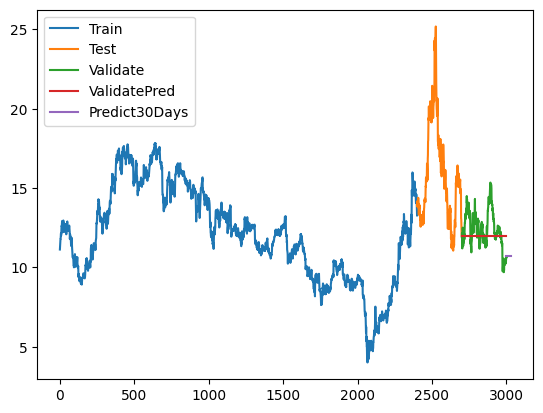

In [11]:
# Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_val_pred)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Validate','ValidatePred','Predict30Days'])
plt.show()